# YOLO-v1
## Keras Tensorflow2.4 实现
## 使用 VOC2007 数据集

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.1


In [3]:
# YOLO 输出层
import tensorflow.keras.backend as K

class YoloOutput(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        """
        :param target_shape: 输出维度
        """
        super(YoloOutput, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        """
        :return: 配置
        """
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, inputs):
        # 网格大小 7 * 7
        S = [self.target_shape[0], self.target_shape[1]]
        # 类别数量
        C = 20
        # 每个格子预测的 bounding box 数量
        B = 2

        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B

        # 类概率
        class_prob = K.reshape(inputs[:, :idx1], (K.shape(inputs)[0],) + tuple([S[0], S[1], C]))
        class_prob = K.softmax(class_prob)

        # 置信度
        confidence = K.reshape(inputs[:, idx1:idx2], (K.shape(inputs)[0],) + tuple([S[0], S[1], B]))
        confidence = K.sigmoid(confidence)

        # boxes
        boxes = K.reshape(inputs[:, idx2:], (K.shape(inputs)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)

        outputs = K.concatenate([class_prob, confidence, boxes])
        return outputs

In [4]:
# YOLO 网络
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
# 第一层
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
# 第二层
model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
# 第三层
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
# 第四层
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
# 第五层
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))
# 第六层
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
# 第七层
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(YoloOutput(target_shape=(7,7,30)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 448, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 192)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     6

In [5]:
# 计算损失
import tensorflow.keras.backend as K

def xywh2minmax(xy, wh):
    """
    根据 label(x, y, w, h) 得到边界
    :param xy: 中心点
    :param wh: 长宽
    :return: 边界
    """
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    """
    计算 IOU
    :param pred_mins: 预测框左坐标
    :param pred_maxes: 预测框右坐标
    :param true_mins: 实际框左坐标
    :param true_maxes: 实际框右坐标
    :return: IOU
    """
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    """
    损失函数
    :param y_true: 实际值
    :param y_pred: 预测值
    :return: 损失
    """
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_iou = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_iou, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_iou >= best_box, K.dtype(best_iou))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [6]:
# 完成模型
model.compile(loss=yolo_loss ,optimizer='adam')

In [48]:
# 预测模型
import cv2
import numpy as np

model.load_weights('../input/voc2007/weight.hdf5')

image_path = '../input/voc2007/VOC2007/VOC2007/JPEGImages/000207.jpg'
label = '1,205,113,320,5'
image = cv2.imread(image_path)

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (448, 448))
# input_image = input_image / 255. * 2. -1.
input_image = np.expand_dims(input_image, 0)

netout = model.predict(input_image)

<Figure size 720x720 with 0 Axes>

In [49]:
print(netout.shape)

(1, 7, 7, 30)


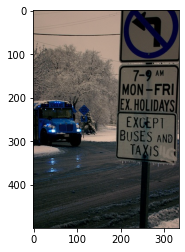

In [50]:
plt.imshow(image)
plt.show()

In [51]:
class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

In [52]:
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b)

In [53]:
car_class_num = 6

boxes = []
cell_num = 7
class_num = 20
bounding_box_num = 2
grid_size = cell_num * cell_num
prob_size = grid_size * class_num
conf_size = grid_size * bounding_box_num

netout = netout.reshape(-1)

In [54]:
probs = netout[0:prob_size]
confs = netout[prob_size:(prob_size+conf_size)]
cords = netout[(prob_size+conf_size):]

probs = probs.reshape((grid_size, class_num))
confs = confs.reshape((grid_size, bounding_box_num))
cords = cords.reshape((grid_size, bounding_box_num, 4))
# 找到全部置信度大于0.2的汽车box
for grid in range(grid_size):
    for b in range(bounding_box_num):
        bx = Box()
        bx.c = confs[grid, b]
        bx.x = (cords[grid, b, 0] + grid % cell_num) / cell_num
        bx.y = (cords[grid, b, 1] + grid // cell_num) / cell_num
        bx.w = cords[grid, b, 2] ** 1.8
        bx.h = cords[grid, b, 3] ** 1.8
        p = probs[grid, :] * bx.c
        if p[car_class_num] >= 0.2:
            bx.prob = p[car_class_num]
            boxes.append(bx)
# 对box的置信度进行排序
boxes.sort(key=lambda b: b.prob, reverse=True)
# 对于两个IOU大于0.4的box，保留置信度高的那个
for i in range(len(boxes)):
    boxi = boxes[i]
    if boxi.prob == 0:
        continue
    for j in range(i + 1, len(boxes)):
        boxj = boxes[j]
        if box_iou(boxi, boxj) >= 0.4:
            boxes[j].prob = 0

boxes = [b for b in boxes if b.prob > 0]

In [74]:
print(len(boxes))
print(boxes[0].x * 448)
print(boxes[0].y * 448)
print(boxes[0].h * 448)
print(boxes[0].w * 448)

12
65.89650690555573
5.155240058898926
0.0017749822643571167
4.810631259846376


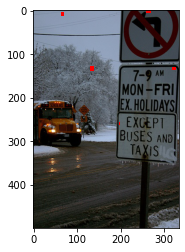

In [72]:
import matplotlib.patches as patches
img = plt.imread(image_path)
for b in boxes:
    left = int((b.x * 448 - b.w * 448 / 2.))
    right = int((b.x * 448 + b.w * 448 / 2.))
    top = int((b.y * 448 - b.h * 448 / 2.))
    bot = int((b.y * 448 + b.h * 448 / 2.))
    ptLeftTop = (left, top)
    ptRightBottom = (right, bot)
    point_color = (0, 255, 0) # BGR
    thickness = 1
    lineType = 4
    rect = patches.Rectangle((b.x * 448, b.y * 448), b.h * 448, b.w * 448, linewidth=2, edgecolor='r', facecolor='none')
    currentAxis = plt.gca()
    currentAxis.add_patch(rect)
plt.imshow(img)
plt.show()